# Whole-volume vs mean across slices Dice comparison

This notebook compares the computation of Dice as either Mean Dice across 2D slices Dice values and Single Dice value computed from the whole volume.
This is to test the discrepancy observed when performing validation with sliding window (i.e. whole volume Dice) as opposed to mean over slices randomly extracted from the validation set.

Purpose: When using the sliding window approach at validation, the validation curve actually shows better performance than the training. I want to test the hypothesis that computing the Dice over the whole volume may have some "regularisation effect" that produces lower Dice score as opposed to computing it as a mean of Dice scores from 2D slices.

In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
# !{sys.executable} -m pip install seaborn --user
abs_dir="/mnt/data/mranzini"
# abs_dir="/Users/Marta/Desktop/mountpoint"
sys.path.append(os.path.join(*[abs_dir, "Code", "Demic-v0.1"]))
import pandas as pd
from Demic.util.image_process import *
from Demic.image_io.file_read_write import *

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice 

In [3]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    return img

In [8]:
def get_all_dice(group="GroupA", remove_outliers=False):

    MAIN_DIR = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Retraining_with_expanded_dataset"])
    folder_segment_guotai = os.path.join(*[MAIN_DIR, "inference", "guotai"])
    folder_segment_retrained = os.path.join(*[MAIN_DIR, "inference", "expanded"])
    folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "runs", "2020-04-28_18-54-11", "inference_with_postprocessing"])
    folder_gt1 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset"])
    folder_gt2 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset_extension"])

    params_dict = {'GroupA': os.path.join(folder_gt1, "list_inference_h_subjects.txt"),
                  'GroupB1': os.path.join(folder_gt1, "list_inference_p1_subjects.txt"),
                  'GroupB2': os.path.join(folder_gt1, "list_inference_p2_subjects.txt"),
                  'GroupC': os.path.join(*[folder_gt2, "splitting_list", "list_inference_C.txt"]),
                  'GroupD': os.path.join(*[folder_gt2, "splitting_list", "list_inference_D.txt"]),
                  'GroupE': os.path.join(*[folder_gt2, "splitting_list", "list_inference_E.txt"]),
                  'GroupF': os.path.join(*[folder_gt2, "splitting_list", "list_inference_F.txt"])
                  }
    
    gt_dict = {'GroupA': folder_gt1,
               'GroupB1': folder_gt1,
               'GroupB2': folder_gt1,
               'GroupC': folder_gt2,
               'GroupD': folder_gt2,
               'GroupE': folder_gt2,
               'GroupF': folder_gt2}

    dice_vals = {"subj_id": [], "whole_volume": [], "mean_2D": []}
    subj_list = params_dict[group]
    folder_gt = gt_dict[group]
    with open(subj_list) as r:
        lines = r.readlines()
        for l in lines:
            print(l)
            all_stacks = sorted(glob.glob(os.path.join(*[folder_gt, group, l.rstrip() + '*_Label.nii.gz'])))
            for s in all_stacks:
                scan_id = os.path.basename(s)
                scan_id = scan_id.split("_Label", 1)[0]
                if scan_id == "b79_16":
                    # original image is corrupted
                    continue
                dice_vals["subj_id"].append(scan_id)
                
                # get the ground truth
                gt = np.squeeze(read_nifti(s))
                
                # extract dice from basic unet in monai
                monai_file = os.path.join(*[folder_unet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                monai_segment = np.squeeze(read_nifti(monai_file))
                if(remove_outliers):
                    strt = ndimage.generate_binary_structure(3,2) # iterate structure
                    post_monai = ndimage.morphology.binary_closing(monai_segment, strt)
                    post_monai = get_largest_component(post_monai)
                    monai_segment = np.asarray(post_monai*monai_segment, np.uint8)
                dice_vals["whole_volume"].append(compute_dice(gt, monai_segment))
                
                # compute the dice from the 2D slices and then average it
                mean_dice_2D = 0.0
                for idx_slice in range(0, np.size(gt, 0)):
                    mean_dice_2D += compute_dice(gt[idx_slice, ...], monai_segment[idx_slice, ...])
                dice_vals["mean_2D"].append(mean_dice_2D / np.size(gt, 0))

    dice_vals["whole_volume"] = np.asarray(dice_vals["whole_volume"])
    dice_vals["mean_2D"] = np.asarray(dice_vals["mean_2D"])

    return dice_vals

In [9]:
remove_outlier = True
dice_groupA = get_all_dice(group="GroupA", remove_outliers=remove_outlier)
# dice_groupB1 = get_all_dice(group="GroupB1", remove_outliers=remove_outlier)
# dice_groupB2 = get_all_dice(group="GroupB2", remove_outliers=remove_outlier)
# dice_groupC = get_all_dice(group="GroupC", remove_outliers=remove_outlier)
# dice_groupD = get_all_dice(group="GroupD", remove_outliers=remove_outlier)
# dice_groupE = get_all_dice(group="GroupE", remove_outliers=remove_outlier)
# dice_groupF = get_all_dice(group="GroupF", remove_outliers=remove_outlier)

a02

a06

a17

a24

a26

b18

b79



Text(0, 0.5, 'Mean Dice from 2D slices')

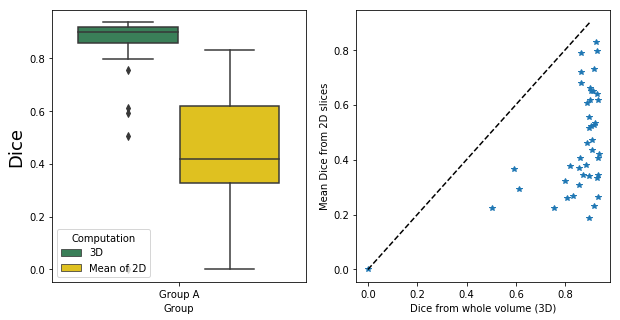

In [21]:
import pandas as pd

pd1 = pd.DataFrame(data={'Group': 'Group A', 'Dice': dice_groupA['whole_volume'], 'Computation': '3D'})
pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['mean_2D'], 'Computation': 'Mean of 2D'}))

fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
# plt.figure(figsize=(6, 5))
b1 = sns.boxplot(x='Group', y='Dice', hue='Computation', data=pd1, palette=['seagreen', 'gold'], ax=ax[0])
b1.set_ylabel('Dice', fontsize=18)
ax[1].plot(dice_groupA['whole_volume'], dice_groupA['mean_2D'], '*')
ax[1].plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), 'k--')
ax[1].set_xlabel('Dice from whole volume (3D)')
ax[1].set_ylabel('Mean Dice from 2D slices')